### Clustering of Tweets

Having done the embeddings, can we find meaningful structure in the data? We have seen some nice preliminary results based on visualization tools. Most importantly, hashtags (topics) seem to define clusters. 


Some questions of interest which relate directly to polarization in US politics
- Clustering all tweets, do we get two meaningful cluster representing left and right (extremes)
- What are inter- and intra-cluster dissimilarities?
- Are users consistently tweeting inside one cluster or are they changing?
- The best indicator for polarization would be to find two clusters which are very different
- We can further check whether there are distinct cluster in one particular topic. For example we take the BlackLivesMatter hashtag and check whether tweets in this hashtag seperate and thus try to polarize the discussion.


### How can we cluster?

##### K-means
- Classical centroid based approach
- Influenced by noise
- Find optimal nr of clusters based on elbow method
- Might need multiple runs due to convergence to local optima
- Key disadvantage: "Spherical clusters", does not allow for intricate shapes

##### DBScan
- Density based approach
- Group points together that are in a dense region
- Allows for more intricate structures
- Allows for noise and outliers

How DBScan Works:
- Minimum density level estimation, based on a threshold for the number of neighbors, $minPts$ within the radius $\epsilon$ with an arbitrary distance measure
- Objects with more than $minPts$ neighbors within this radius are considered core points
- The intuition behind DBSCAN is to find the areas which satisfy the minimum density and which are seperated by areas of lower density
- All neighbors within the $\epsilon$ radius of a core point are considered to be part of the same cluster as the core point ("direct-density-reachable")
- If any of these neighbors is again a core point, their neighborhoods are density reachable
- Non-core points are called border points and all points within the same set are density connected
- Points which are not density reachable from any core point are considered noise and do not belong to any cluster

DBScan Params:
- eps: The maximum distance between two samples for one to be considered as in the neighborhood of the other. We have normalized data, so don't need to worry too much about scale
- min_samples: The number of samples (or total weight) in a neighborhood for a point to be considered as a core point. 
- metric
- n_jobs

Heuristics for setting DBScan parameters (as mentioned by developers)
http://www.ccs.neu.edu/home/vip/teach/DMcourse/2_cluster_EM_mixt/notes_slides/revisitofrevisitDBSCAN.pdf
- $minPts$ = ```min_samples``` purpose is to smooth out density estimate. For datasets that have lot of noise, are very large and high dimensional (so definitely ours) it makes sense to reduce the value of minPts below the default of 4 (choose 2-3)
- $\epsilon$ = ```eps```, radius parameter, harder to set. Should be choosen as small as possible. Unfortunately there's no domain knowledge because distances are essentially arbitrary. Better: 𝑘-distance graph (with 𝑘=𝑚𝑖𝑛𝑃𝑡𝑠) and look for an elbow in this graph. We compute the distance of the k-nearest neighbors for a sample of the tweets and look at the elbow plot of distances. Choose ```eps``` as the (hopefully) visible elbow.

#### What do we need to be aware of?
- Curse of dimensionality: We have 100 dimensions due to our embedding
- Parameters: For every algorithm we have to be aware of the parameter choices, in k-means nr of clusters, DBScan


#### Idea: Dimensionality reduction

If the results we get without dimensionality reduction are shit we'll need to think of reducing dimensions.

- Random Projection
- PCA 

In [1]:
# Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import gc

# Clustering algos to test
from sklearn.cluster import DBSCAN, MiniBatchKMeans

# Dimensionality reduction
from sklearn.random_projection import johnson_lindenstrauss_min_dim, GaussianRandomProjection

Loading

In [2]:
with open('../data/tweets_final.pickle', 'rb') as f:
    data = pickle.load(f)

#### K-Means Clustering

- Make Elbow plot
- n_clusters gives the number of centroids
- init: random, start randomly
- n_init: Number of runs over random seeds

Returns:
- cluster_centers: Coordinates of the cluster centers
- labels_ : Labels of each point
- intertia: Sum of squared distances of samples to their closest cluster center

In [4]:
X = data.loc[:,data.columns[-100:]].values

In [14]:
# List to store sum of squared distances
ssqd = []

# Number of random samples to take each size 100.000:
random_samples = 10

# Loop through different choices of k, store sum of squared distances
for k in range(1, 10):
    print(f"k:{k}")
    kmeans = MiniBatchKMeans(n_clusters=k,n_init= 5,batch_size=1000, compute_labels=True)

    temp = []
    for r_n in range(0,random_samples):
        
        sample = X[np.random.randint(0,X.shape[0],size = 100000),:]
        
        kmeans.fit(sample)
        
        temp.append(kmeans.inertia_)
        
    ssqd.append(np.mean(temp))


k:1
k:2
k:3
k:4
k:5
k:6
k:7
k:8
k:9


Elbow plot:

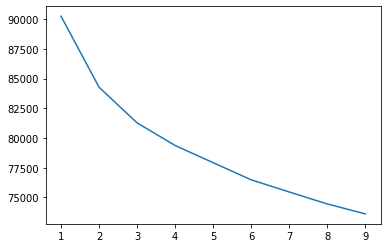

In [16]:
sns.lineplot(x= range(1,10), y = ssqd)

Okay, we get two clusters. Let's cluster the full data set and see whether there's any meaningful structure.

In [17]:
# Kmeans with two clusters
kmeans = MiniBatchKMeans(n_clusters=5,n_init= 5,batch_size=1000, compute_labels=True)

#fit
kmeans.fit(X)
    
# Assign K-Means label
labels  =  kmeans.labels_

data["kmeans_label"] = labels

Let's see whether we can find any information in the clusters found by k-means

In [18]:
data.kmeans_label.mean()

2.1152886378908606

We cluster half the tweets as label 0 the other half as label 1.

In [19]:
# Super conservative account
data[data.user_screen_name == "redlanews"]["kmeans_label"].mean()

2.993560849967804

In [20]:
# Super liberal account
data[data.user_screen_name == "gloed_up"]["kmeans_label"].mean()

2.624780701754386

Well, seems like these guys are more or less in the same cluster. Let's make word-cloud based on the clusters.

In [21]:
# Reload tokenized tweets
with open('../data/tweets_tokenized.pickle', 'rb') as f:
    tweets_tokenized = np.array(pickle.load(f))

In [27]:
labels

array([2, 3, 0, ..., 3, 2, 4], dtype=int32)

In [28]:
cluster1 = tweets_tokenized[labels == 0]
cluster2 = tweets_tokenized[labels == 1]
cluster3 = tweets_tokenized[labels == 2]
cluster4 = tweets_tokenized[labels == 3]
cluster5 = tweets_tokenized[labels == 4]

In [23]:
from utils.wordcloud import plot_wordcloud

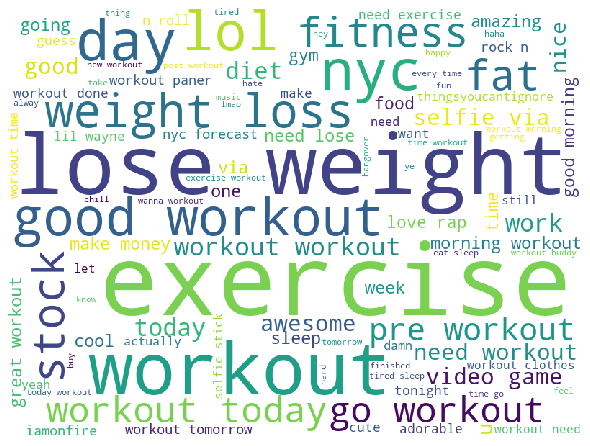

In [24]:
plot_wordcloud(cluster1)

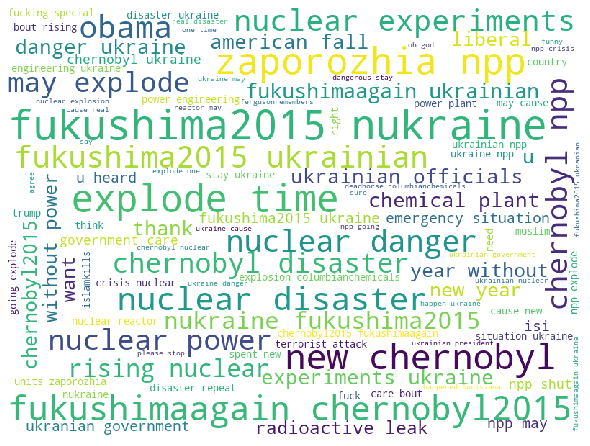

In [25]:
plot_wordcloud(cluster2)

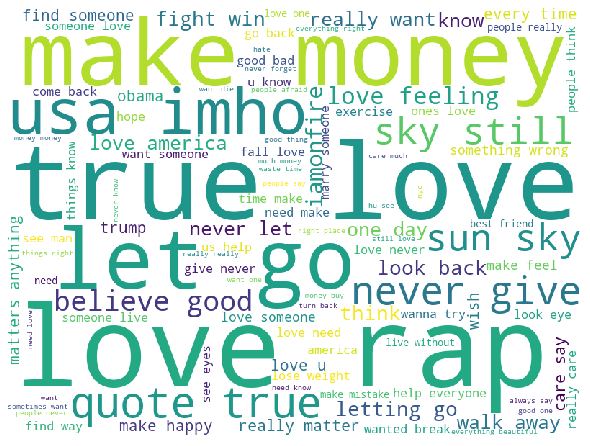

In [29]:
plot_wordcloud(cluster3)

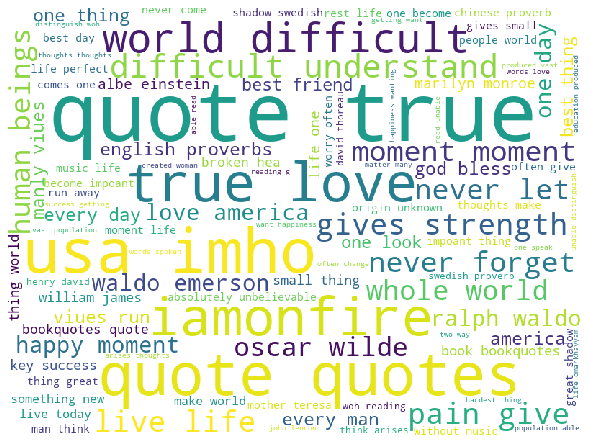

In [30]:
plot_wordcloud(cluster4)

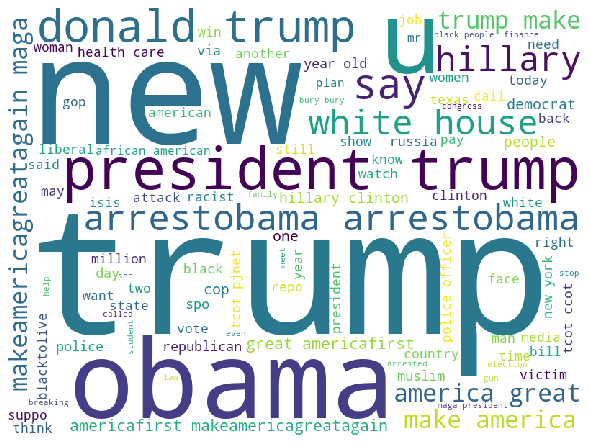

In [31]:
plot_wordcloud(cluster5)